In [33]:
# --- BÖLÜM 1: Kurulum ve Veri Yükleme ---

import warnings
warnings.filterwarnings("ignore")

import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Tohum
np.random.seed(42)

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Yol ayarları (Windows için uygun)
DATA_DIR = "titanic veri"
TRAIN_PATH = os.path.join(DATA_DIR, "train.csv")
TEST_PATH  = os.path.join(DATA_DIR, "test.csv")

df_raw = pd.read_csv(TRAIN_PATH)
print("Train shape:", df_raw.shape)
display(df_raw.head())
display(df_raw.info())
display(df_raw.isna().sum())

Train shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [34]:
# --- BÖLÜM 2: Veri Temizleme (EDA için) ---

df_eda = df_raw.copy()

# EDA için basit doldurma (model pipeline içinde ayrıca imputation var)
age_median = df_eda['Age'].median()
df_eda['Age'] = df_eda['Age'].fillna(age_median)

embarked_mode = df_eda['Embarked'].mode().iloc[0]
df_eda['Embarked'] = df_eda['Embarked'].fillna(embarked_mode)

# PassengerId modelde kullanılmayacak; EDA için tutmaya gerek yok
# Cabin/Ticket sütunlarını EDA'da gerekirse kullanacağız (özellik üretimi için).
display(df_eda.isna().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

In [35]:
# --- BÖLÜM 3: Özellik Mühendisliği (EDA için) ---

df_eda = df_eda.copy()

# FamilySize & IsAlone
df_eda['FamilySize'] = df_eda['SibSp'] + df_eda['Parch'] + 1
df_eda['IsAlone'] = (df_eda['FamilySize'] == 1).astype(int)

# Title
df_eda['Title'] = df_eda['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
df_eda['Title'] = df_eda['Title'].apply(lambda t: t if t in ['Mr','Mrs','Miss','Master'] else 'Rare')

# Ek özellikler
# FarePerPerson
df_eda['FarePerPerson'] = df_eda['Fare'] / df_eda['FamilySize'].replace(0, 1)

# TicketGroupSize
df_eda['TicketGroupSize'] = df_eda.groupby('Ticket')['Ticket'].transform('count')

# CabinInitial (eksikleri 'U')
df_eda['CabinInitial'] = df_eda['Cabin'].astype(str).str[0].replace({'n': 'U'})  # NaN -> 'nan' ilk harf 'n', normalize edelim
df_eda['CabinInitial'] = df_eda['CabinInitial'].replace({'n': 'U', 'N': 'U'}).fillna('U')

# Name'ı EDA sonrası bırak
df_eda = df_eda.drop(columns=['Name'])

display(df_eda.head())

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone,Title,FarePerPerson,TicketGroupSize,CabinInitial
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,0,Mr,3.62500,1,U
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,2,0,Mrs,35.64165,1,C
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1,Miss,7.92500,1,U
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S,2,0,Mrs,26.55000,2,C
4,5,0,3,male,35.0,0,0,373450,8.0500,NaN,S,1,1,Mr,8.05000,1,U


Cinsiyete göre hayatta kalma ortalaması:


Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64


Sınıfa göre hayatta kalma ortalaması:


Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

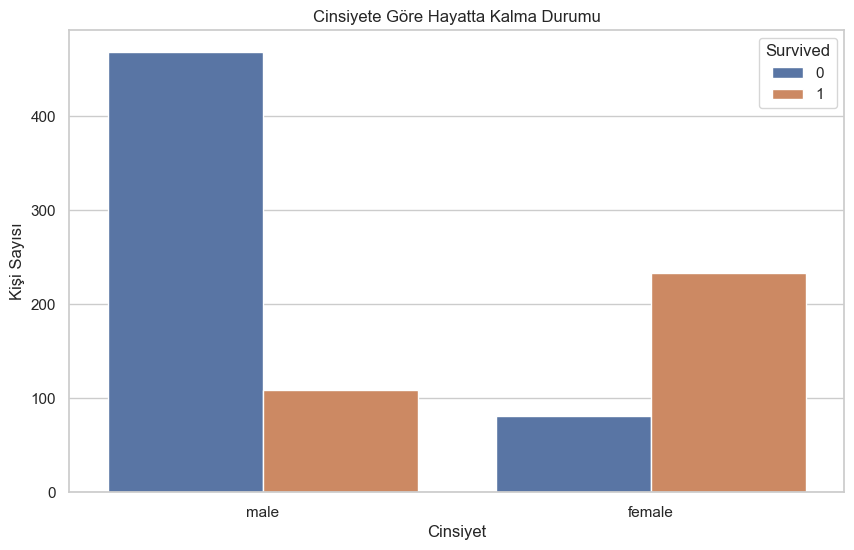

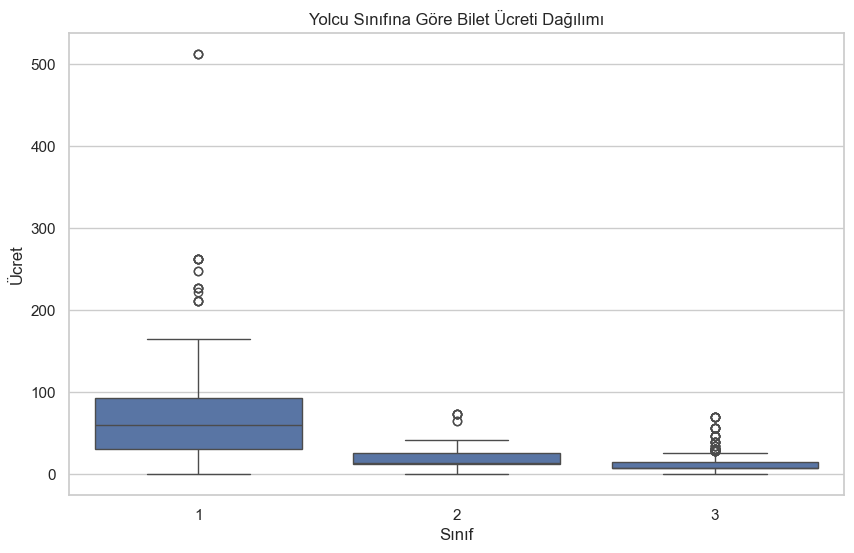

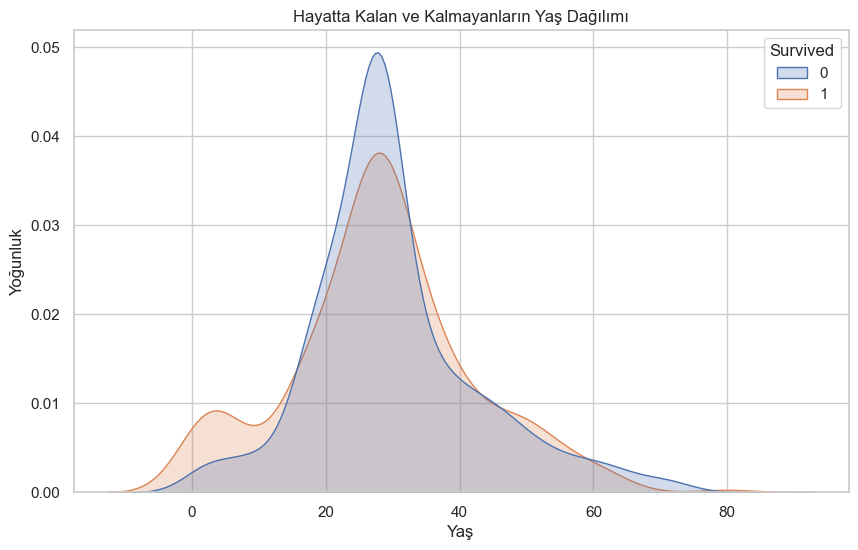

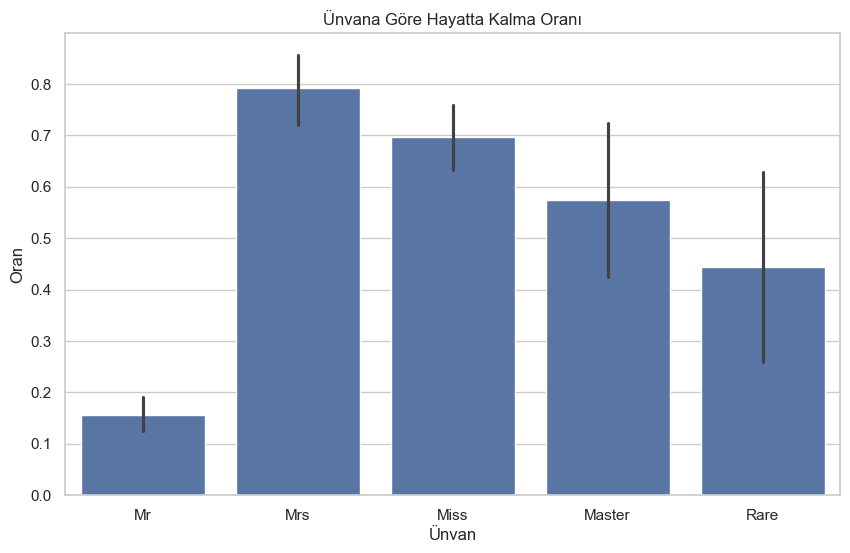

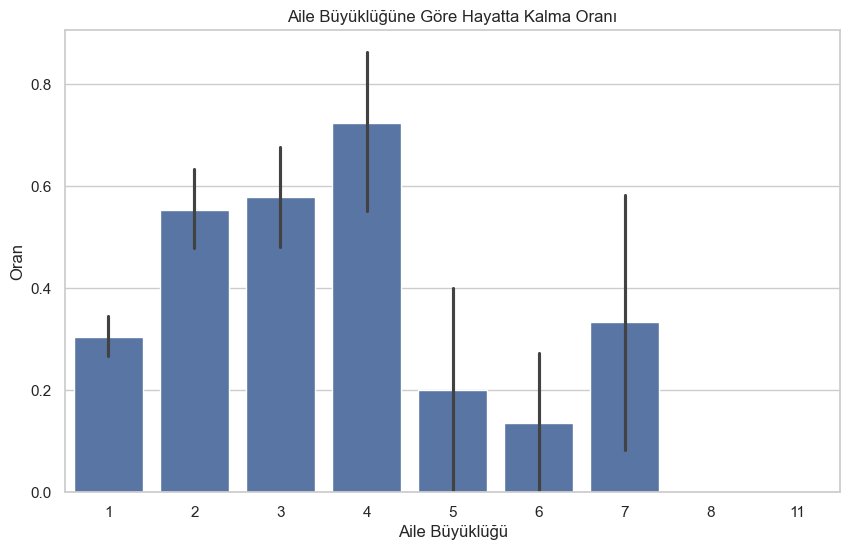

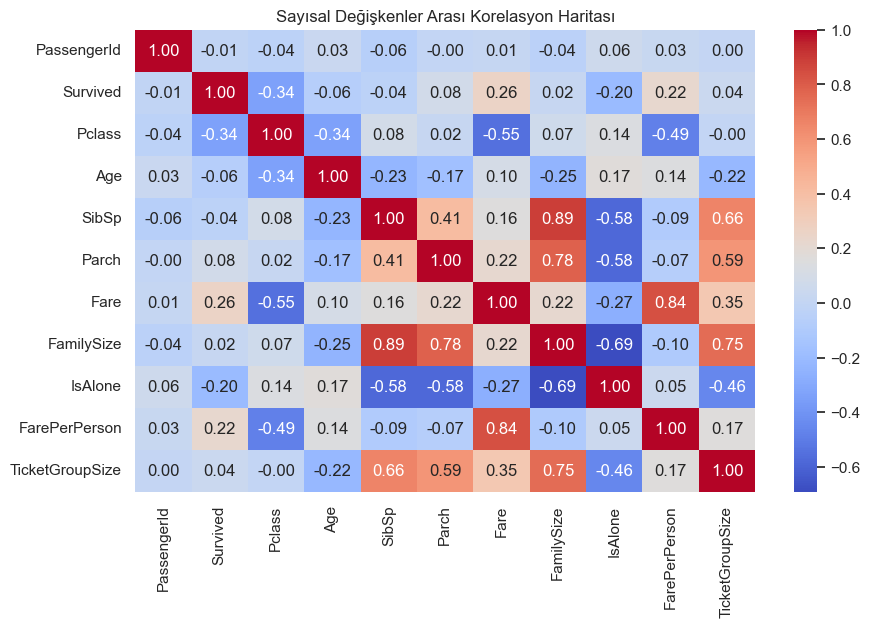

In [36]:
# --- BÖLÜM 4: Keşifsel Veri Analizi (EDA) ve Görselleştirme ---

# Grup Analizi
print("Cinsiyete göre hayatta kalma ortalaması:")
display(df_eda.groupby('Sex')['Survived'].mean().sort_values(ascending=False))

print("\nSınıfa göre hayatta kalma ortalaması:")
display(df_eda.groupby('Pclass')['Survived'].mean())

# Grafik 1: Cinsiyete Göre Hayatta Kalma
sns.countplot(x='Sex', hue='Survived', data=df_eda)
plt.title("Cinsiyete Göre Hayatta Kalma Durumu"); plt.xlabel("Cinsiyet"); plt.ylabel("Kişi Sayısı"); plt.show()

# Grafik 2: Sınıf ve Ücret İlişkisi
sns.boxplot(x='Pclass', y='Fare', data=df_eda)
plt.title("Yolcu Sınıfına Göre Bilet Ücreti Dağılımı"); plt.xlabel("Sınıf"); plt.ylabel("Ücret"); plt.show()

# Grafik 3: Yaş ve Hayatta Kalma KDE
sns.kdeplot(data=df_eda, x='Age', hue='Survived', fill=True, common_norm=False)
plt.title("Hayatta Kalan ve Kalmayanların Yaş Dağılımı"); plt.xlabel("Yaş"); plt.ylabel("Yoğunluk"); plt.show()

# Grafik 4a: Ünvan - Survived
sns.barplot(x='Title', y='Survived', data=df_eda, estimator=np.mean, order=['Mr','Mrs','Miss','Master','Rare'])
plt.title("Ünvana Göre Hayatta Kalma Oranı"); plt.xlabel("Ünvan"); plt.ylabel("Oran"); plt.show()

# Grafik 4b: FamilySize - Survived
sns.barplot(x='FamilySize', y='Survived', data=df_eda, estimator=np.mean)
plt.title("Aile Büyüklüğüne Göre Hayatta Kalma Oranı"); plt.xlabel("Aile Büyüklüğü"); plt.ylabel("Oran"); plt.show()

# Grafik 5: Korelasyon Isı Haritası (sayısal)
corr = df_eda.select_dtypes(include=[np.number]).corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Sayısal Değişkenler Arası Korelasyon Haritası"); plt.show()

In [37]:
# --- BÖLÜM 5: Makine Öğrenmesine Hazırlık (X, y ve Stratified Split) ---

# Model pipeline, ham kolonlardan gerekli türevleri üretecek.
BASE_FEATURES = ['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked','Name','Ticket','Cabin']

X = df_raw[BASE_FEATURES].copy()
y = df_raw['Survived'].astype(int).copy()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"X_train: {X_train.shape} | X_test: {X_test.shape}")
print(f"y dağılımı (train): {y_train.mean():.4f} | (test): {y_test.mean():.4f}")

X_train: (712, 10) | X_test: (179, 10)
y dağılımı (train): 0.3834 | (test): 0.3855


In [38]:
# --- BÖLÜM 6: Pipeline + ColumnTransformer ve Model Adayları ---

from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import copy

def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # FamilySize, IsAlone
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    # Title
    title = df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
    title = title.apply(lambda t: t if t in ['Mr','Mrs','Miss','Master'] else 'Rare')
    df['Title'] = title
    # FarePerPerson
    df['FarePerPerson'] = df['Fare'] / df['FamilySize'].replace(0, 1)
    # TicketGroupSize
    df['TicketGroupSize'] = df.groupby('Ticket')['Ticket'].transform('count')
    # CabinInitial
    cab = df['Cabin'].astype(str).str[0]
    cab = cab.replace({'n':'U','N':'U'}).fillna('U')
    df['CabinInitial'] = cab
    return df

feature_adder = FunctionTransformer(add_features, validate=False)

num_features = ['Age','Fare','SibSp','Parch','FamilySize','IsAlone','FarePerPerson','TicketGroupSize']
cat_features = ['Sex','Pclass','Embarked','Title','CabinInitial']

numeric_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe',     OneHotEncoder(handle_unknown='ignore'))
])

pre = ColumnTransformer(
    transformers=[
        ('num', numeric_pipe, num_features),
        ('cat', categorical_pipe, cat_features)
    ],
    remainder='drop'
)

base_pipe = Pipeline(steps=[
    ('feat', feature_adder),
    ('pre',  pre),
    ('clf',  LogisticRegression(max_iter=1000, random_state=42))
])

# Model adayları
models = {}
models['LogReg'] = copy.deepcopy(base_pipe)
models['LogReg'].set_params(clf=LogisticRegression(max_iter=1000, random_state=42))

models['LogReg_bal'] = copy.deepcopy(base_pipe)
models['LogReg_bal'].set_params(clf=LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))

models['RF'] = copy.deepcopy(base_pipe)
models['RF'].set_params(clf=RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1))

models['RF_bal'] = copy.deepcopy(base_pipe)
models['RF_bal'].set_params(clf=RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42, n_jobs=-1))

# Opsiyonel boosting modelleri
available_boosters = []
try:
    import xgboost as xgb
    models['XGB'] = copy.deepcopy(base_pipe)
    models['XGB'].set_params(clf=xgb.XGBClassifier(
        n_estimators=400, max_depth=4, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.9, n_jobs=-1, random_state=42, eval_metric='logloss'
    ))
    available_boosters.append('XGB')
except Exception:
    pass

try:
    from lightgbm import LGBMClassifier
    models['LGBM'] = copy.deepcopy(base_pipe)
    models['LGBM'].set_params(clf=LGBMClassifier(
        n_estimators=600, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.9, random_state=42, n_jobs=-1
    ))
    available_boosters.append('LGBM')
except Exception:
    pass

try:
    from catboost import CatBoostClassifier
    models['CAT'] = copy.deepcopy(base_pipe)
    models['CAT'].set_params(clf=CatBoostClassifier(
        iterations=600, depth=5, learning_rate=0.05,
        random_state=42, verbose=False
    ))
    available_boosters.append('CAT')
except Exception:
    pass

print("Kullanılacak modeller:", list(models.keys()))

Kullanılacak modeller: ['LogReg', 'LogReg_bal', 'RF', 'RF_bal']


In [39]:
# --- BÖLÜM 7: Cross-Validation (StratifiedKFold) ---

from sklearn.model_selection import StratifiedKFold, cross_validate

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rows = []
for name, pipe in models.items():
    scores = cross_validate(
        pipe, X_train, y_train, cv=skf,
        scoring=['accuracy','f1','roc_auc'], n_jobs=-1, return_train_score=False
    )
    rows.append({
        'model': name,
        'acc_mean': scores['test_accuracy'].mean(),
        'acc_std':  scores['test_accuracy'].std(),
        'f1_mean':  scores['test_f1'].mean(),
        'f1_std':   scores['test_f1'].std(),
        'auc_mean': scores['test_roc_auc'].mean(),
        'auc_std':  scores['test_roc_auc'].std(),
    })

cv_results = pd.DataFrame(rows).sort_values(by=['f1_mean','auc_mean'], ascending=False)
display(cv_results.reset_index(drop=True))
best_name = cv_results.iloc[0]['model']
print("CV'e göre en iyi aday:", best_name)

,model,acc_mean,acc_std,f1_mean,f1_std,auc_mean,auc_std
0,LogReg_bal,0.814646,0.044043,0.771248,0.042980,0.866804,0.021402
1,LogReg,0.821668,0.026643,0.764858,0.031437,0.868182,0.020985
2,RF_bal,0.813237,0.012489,0.753326,0.012739,0.874157,0.012814
3,RF,0.806225,0.016429,0.747669,0.015285,0.876088,0.014335


CV'e göre en iyi aday: LogReg_bal


Test Accuracy: 0.8212 | F1: 0.7714

Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0     0.8611    0.8455    0.8532       110
           1     0.7606    0.7826    0.7714        69

    accuracy                         0.8212       179
   macro avg     0.8108    0.8140    0.8123       179
weighted avg     0.8224    0.8212    0.8217       179



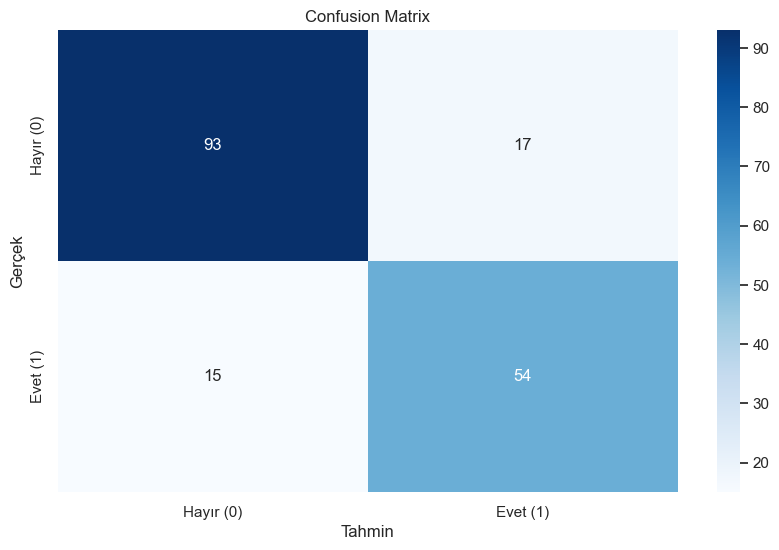

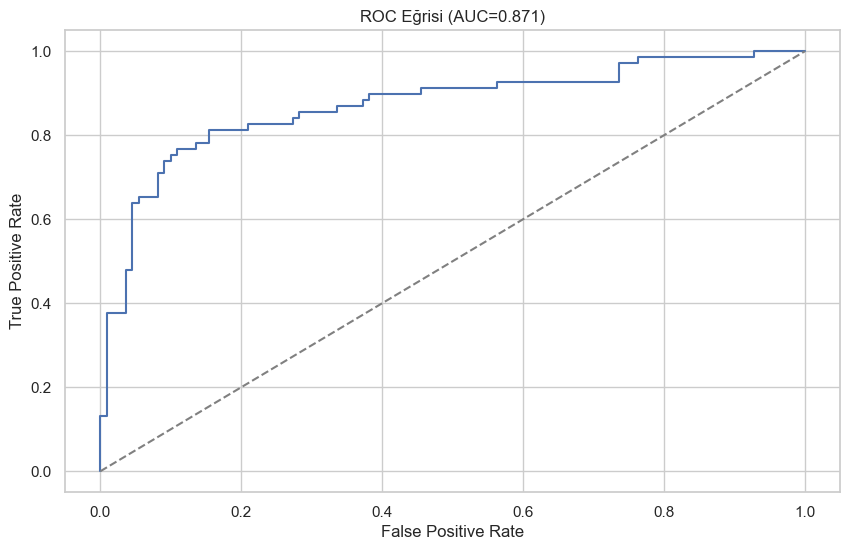

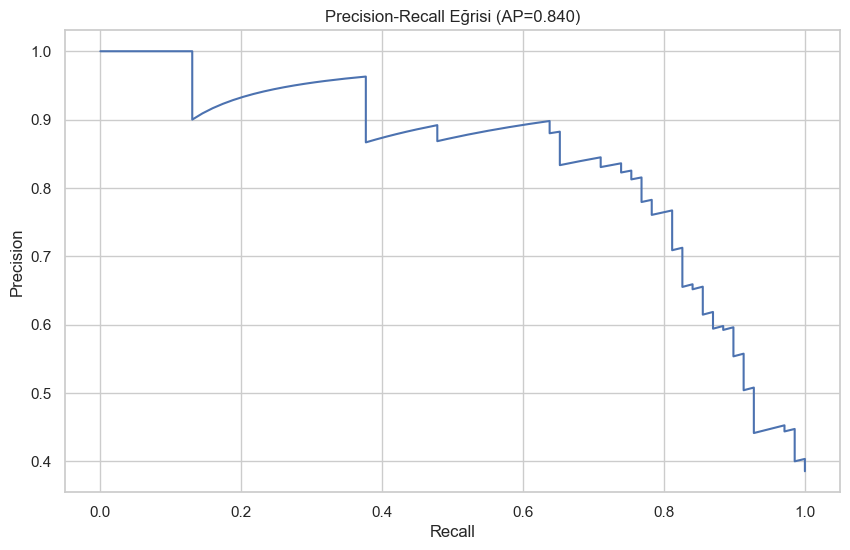

In [40]:
# --- BÖLÜM 8: Nihai Eğitim ve Test Değerlendirme (ROC/PR/CM) ---

from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
)

best_pipe = copy.deepcopy(models[best_name])
best_pipe.fit(X_train, y_train)

y_pred = best_pipe.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f} | F1: {f1:.4f}")
print("\nSınıflandırma Raporu:\n", classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Hayır (0)','Evet (1)'],
            yticklabels=['Hayır (0)','Evet (1)'])
plt.title("Confusion Matrix"); plt.xlabel("Tahmin"); plt.ylabel("Gerçek"); plt.show()

# Olasılık / skor üretimi
if hasattr(best_pipe, "predict_proba"):
    y_prob = best_pipe.predict_proba(X_test)[:, 1]
elif hasattr(best_pipe, "decision_function"):
    raw_scores = best_pipe.decision_function(X_test)
    y_prob = (raw_scores - raw_scores.min()) / (raw_scores.max() - raw_scores.min() + 1e-9)
else:
    # Son çare: sınıf tahminlerini olasılık varsayımı gibi kullanmak (çok nadir gerekir)
    y_prob = y_pred.astype(float)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.title(f"ROC Eğrisi (AUC={roc_auc:.3f})"); plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.show()

# Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)
plt.plot(rec, prec)
plt.title(f"Precision-Recall Eğrisi (AP={ap:.3f})"); plt.xlabel("Recall"); plt.ylabel("Precision")
plt.show()

In [41]:
# --- BÖLÜM 9: Random Forest Hiperparametre Optimizasyonu (GridSearchCV) ---

from sklearn.model_selection import GridSearchCV

rf_grid = {
    'clf__n_estimators': [200, 400, 800],
    'clf__max_depth': [None, 5, 10, 20],
    'clf__min_samples_split': [2, 5, 10]
}

rf_pipe = copy.deepcopy(base_pipe)
rf_pipe.set_params(clf=RandomForestClassifier(random_state=42, n_jobs=-1))

gs = GridSearchCV(rf_pipe, rf_grid, cv=skf, scoring='f1', n_jobs=-1, verbose=0)
gs.fit(X_train, y_train)

print("En iyi RF parametreleri:", gs.best_params_)
print("En iyi CV F1:", gs.best_score_)

rf_best = gs.best_estimator_
y_pred_rf = rf_best.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf  = f1_score(y_test, y_pred_rf)
print(f"RF (GridSearch) Test Accuracy: {acc_rf:.4f} | F1: {f1_rf:.4f}")

En iyi RF parametreleri: {'clf__max_depth': 10, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
En iyi CV F1: 0.7695730195730195
RF (GridSearch) Test Accuracy: 0.8101 | F1: 0.7385


In [42]:
# --- BÖLÜM 10: Özellik Önemi ve SHAP Özet ---

# Nihai kullanılacak model: RF GridSearch veya CV en iyi model (hangisi daha iyi ise)
final_pipe = rf_best if f1_rf >= f1 else best_pipe
print("Final model:", "RF (GridSearch)" if final_pipe is rf_best else best_name)

# Preprocess sonrası feature adları
pre_step = final_pipe.named_steps['pre']
num_names = np.array(num_features)
cat_ohe = pre_step.named_transformers_['cat'].named_steps['ohe']
cat_names = cat_ohe.get_feature_names_out(cat_features)
feature_names = np.r_[num_names, cat_names]

# Model importances (varsa)
clf = final_pipe.named_steps['clf']
if hasattr(clf, "feature_importances_"):
    importances = pd.Series(clf.feature_importances_, index=feature_names).sort_values(ascending=False)
    display(importances.head(20))
    plt.figure(figsize=(10,6))
    sns.barplot(x=importances.head(20).values, y=importances.head(20).index, orient='h')
    plt.title("Özellik Önemleri (İlk 20)"); plt.xlabel("Önem"); plt.ylabel("Özellik"); plt.show()
else:
    print("Bu model feature_importances_ sağlamıyor.")

# SHAP (varsa ve ağaç tabanlıysa)
try:
    import shap
    # Pipeline’dan transform edilmiş X_train
    Xtr_trans = pre_step.transform(feature_adder.transform(X_train))
    if hasattr(clf, "predict_proba"):
        explainer = shap.TreeExplainer(clf)
        shap_values = explainer.shap_values(Xtr_trans)
        # Çok sınıflı değiliz; shap_values sınıf listesi olabilir
        sv = shap_values[1] if isinstance(shap_values, list) and len(shap_values) > 1 else shap_values
        shap.summary_plot(sv, Xtr_trans, feature_names=feature_names, show=True)
    else:
        print("SHAP: Bu model için TreeExplainer uygun değil.")
except Exception as e:
    print("SHAP kullanılamadı:", str(e))

Final model: LogReg_bal
Bu model feature_importances_ sağlamıyor.
SHAP kullanılamadı: No module named 'shap'


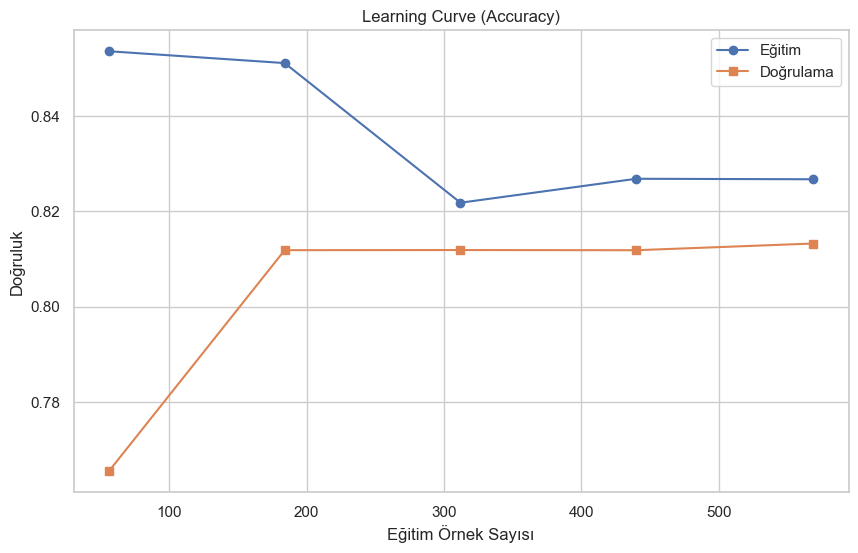

In [43]:
# --- BÖLÜM 11: Learning Curve ve Validation Curve ---

from sklearn.model_selection import learning_curve, validation_curve

# Hücre bağımsız çalıştırılırsa clf lazım:
clf = final_pipe.named_steps['clf']

train_sizes, tr_scores, va_scores = learning_curve(
    final_pipe, X_train, y_train, cv=skf,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring='accuracy', n_jobs=-1
)

tr_mean = tr_scores.mean(axis=1)
va_mean = va_scores.mean(axis=1)

plt.plot(train_sizes, tr_mean, marker='o', label='Eğitim')
plt.plot(train_sizes, va_mean, marker='s', label='Doğrulama')
plt.title("Learning Curve (Accuracy)"); plt.xlabel("Eğitim Örnek Sayısı"); plt.ylabel("Doğruluk")
plt.legend(); plt.show()

# Validation curve (ör: RF n_estimators)
if isinstance(clf, RandomForestClassifier):
    param_range = [50, 100, 200, 400, 800]
    tr_v, va_v = validation_curve(
        final_pipe, X_train, y_train, cv=skf,
        param_name='clf__n_estimators', param_range=param_range,
        scoring='f1', n_jobs=-1
    )
    plt.plot(param_range, tr_v.mean(axis=1), marker='o', label='Eğitim')
    plt.plot(param_range, va_v.mean(axis=1), marker='s', label='Doğrulama')
    plt.title("Validation Curve (RF n_estimators, F1)"); plt.xlabel("n_estimators"); plt.ylabel("F1")
    plt.xscale('log', base=2)
    plt.legend(); plt.show()

In [44]:
# --- BÖLÜM 12: Model Kaydı ve Yükleme ---

from joblib import dump, load

MODEL_PATH = "model.pkl"
dump(final_pipe, MODEL_PATH)
print("Model kaydedildi:", MODEL_PATH)

loaded = load(MODEL_PATH)
print("Model yüklendi. Test yeniden değerlendirme:")
yp = loaded.predict(X_test)
acc_v = accuracy_score(y_test, yp)
f1_v  = f1_score(y_test, yp)
print(f"Accuracy: {acc_v:.4f} | F1: {f1_v:.4f}")

Model kaydedildi: model.pkl
Model yüklendi. Test yeniden değerlendirme:
Accuracy: 0.8212 | F1: 0.7714


In [45]:
# --- BÖLÜM 13: Kaggle Submission Üretimi ve Doğrulama ---

# 1) Test verisini yükle
test_df_raw = pd.read_csv(TEST_PATH).copy()
passenger_id = test_df_raw['PassengerId'].copy()

# 2) BASE_FEATURES kontrolü
missing = set(BASE_FEATURES) - set(test_df_raw.columns)
assert not missing, f"Test setinde eksik kolon(lar): {missing}"

# 3) Model seçimi (final_pipe öncelikli, sonra rf_best -> best_pipe -> fallback)
chosen_pipe = None
if 'final_pipe' in globals():
    chosen_pipe = final_pipe
elif 'rf_best' in globals():
    chosen_pipe = rf_best
elif 'best_pipe' in globals():
    chosen_pipe = best_pipe
else:
    print("Uyarı: final_pipe/rf_best/best_pipe bulunamadı. RF tabanlı fallback pipeline eğitiliyor...")
    fallback_pipe = copy.deepcopy(base_pipe)
    fallback_pipe.set_params(clf=RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1))
    fallback_pipe.fit(X, y)  # tüm eğitim verisiyle
    chosen_pipe = fallback_pipe

# 4) Tahmin ve kayıt
test_pred = chosen_pipe.predict(test_df_raw[BASE_FEATURES]).astype(int)

submission = pd.DataFrame({'PassengerId': passenger_id, 'Survived': test_pred})
submission_path = "submission.csv"
submission.to_csv(submission_path, index=False)

print("submission.csv yazıldı. Şekil:", submission.shape)
display(submission.head())

submission.csv yazıldı. Şekil: (418, 2)


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
